# Train MNIST dataset with PyTorch Data Loading and flax

## 1. Loading data

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_datasets(num_epochs, batch_size):
    # Load MNIST train and test datasets into memory
    train_ds = tfds.load('mnist', split='train')
    test_ds = tfds.load('mnist', split='test')

    train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                            'label': sample['label']}) # Normalize train set
    test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                            'label': sample['label']})

    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # prefetch next sample to improve latency
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

7


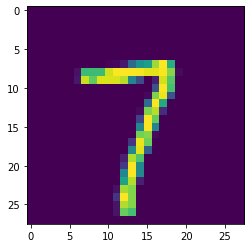

In [3]:
train_ds, test_ds = get_datasets(10, 32)
check_train = next(iter(train_ds))
print(check_train['label'][0].numpy())
plt.imshow(check_train['image'][0])
plt.plot()
pass
# check_test = test_ds['image'][0]

## 2. Define a network

In [4]:
from flax import linen as nn # Linen API

class CNN(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1)) # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

## 3. View Model Layers

In [5]:
import jax
import jax.numpy as jnp

cnn = CNN()
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)))) # (batch, h, w, channel)


                                         CNN Summary                                         
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs              ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,1]  │ float32[1,10]       │                            │
├─────────┼────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,1]  │ float32[1,28,28,32] │ bias: float32[32]          │
│         │        │                     │                     │ kernel: float32[3,3,1,32]  │
│         │        │                     │                     │                            │
│         │        │                     │                     │ 320 (1.3 KB)               │
├─────────┼────────┼─────────────────────┼─────────────────

## 4. Create a `TrainState`

A common pattern in Flax is to create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state.

In [6]:
from clu import metrics
from flax.training import train_state # Useful dataclass to keep train state
from flax import struct               # Flas dataclass
import optax                          # Common loss functions and optimizers

In [7]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [8]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initializing parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            tx=tx,
            metrics=Metrics.empty())

## 5. Training step

A function that:
- Evaluates the neural network given the parameters and a batch of input images with `TrainState.apply_fn`;
- Computes the cross entropy loss, using the predefined `optax.softmax_cross_entropy_with_integer_labels()`. Note that this function expects integer labels, so there is no need to convert labels to onehot encoding.
- Evaluates the gradient of the loss function using `jax.grad`.
- Applies a pytree of gradients to the optimizer to update the model's parameters.

In [9]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

## 6. Metric computation

In [10]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

## 7. Set Seed and train params

In [11]:
num_epochs = 10
batch_size = 128

train_ds, test_ds = get_datasets(num_epochs, batch_size)

tf.random.set_seed(0)
init_rng = jax.random.PRNGKey(0)

## 8. Initialize the `TrainState`

In [12]:
learning_rate = 0.01
momentum = 0.9

state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng

## 9. Train and evaluate

In [14]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [15]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [16]:
for step, batch in enumerate(train_ds.as_numpy_iterator()):
    state = train_step(state, batch)
    state = compute_metrics(state=state, batch=batch)

    if (step + 1) % num_steps_per_epoch == 0:
        for metric, value in state.metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        state = state.replace(metrics=state.metrics.empty())

        test_state = state
        for test_batch in test_ds.as_numpy_iterator():
            test_state = compute_metrics(state=test_state, batch=test_batch)

        for metric, value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.42136648297309875, accuracy: 87.97743225097656
test epoch: 1, loss: 0.17306926846504211, accuracy: 94.90184020996094
train epoch: 2, loss: 0.13288243114948273, accuracy: 95.99693298339844
test epoch: 2, loss: 0.10673539340496063, accuracy: 96.65464782714844
train epoch: 3, loss: 0.0883684754371643, accuracy: 97.3841552734375
test epoch: 3, loss: 0.09159103780984879, accuracy: 97.05529022216797
train epoch: 4, loss: 0.06936392188072205, accuracy: 97.95005798339844
test epoch: 4, loss: 0.06812607496976852, accuracy: 97.90664672851562
train epoch: 5, loss: 0.05647025257349014, accuracy: 98.32064819335938
test epoch: 5, loss: 0.06492280215024948, accuracy: 97.8565673828125
train epoch: 6, loss: 0.0496203750371933, accuracy: 98.51095581054688
test epoch: 6, loss: 0.060647640377283096, accuracy: 97.94671630859375
train epoch: 7, loss: 0.04182353615760803, accuracy: 98.76969909667969
test epoch: 7, loss: 0.060268696397542953, accuracy: 97.72636413574219
train epoch: 8,

## 10. Visualize metrics

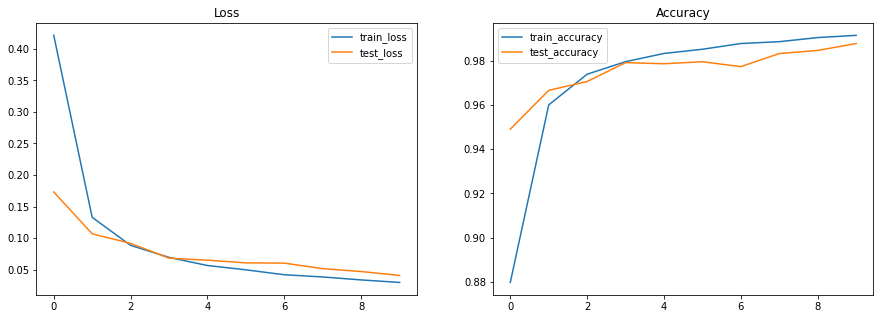

<Figure size 432x288 with 0 Axes>

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()